<a href="https://colab.research.google.com/github/letruong711/Neural-Networks-and-Pneumonia/blob/main/Transfer_Learning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#get more RAM in this notebook
[1]*9**10

# **Install Libraries.**

In [ ]:
#install talos
!pip install talos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import glob
import random

import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import datetime

import talos

# **Setting Google Drive and Establishing Pathways.**

In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#setting up bridge between collab and drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
fid = drive.ListFile({'q': "title='archive.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id':fid})
f.GetContentFile('archive.zip')

In [ ]:
#unzip massive file.
!unzip archive.zip

In [8]:
PATH = '/content/chest_xray'

In [9]:
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')
val_dir = os.path.join(PATH, 'val')

# **Preprocessing.**

In [10]:
#create function that helps us visualize our model
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [11]:
#set image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
batch_size = 624

In [12]:
image_gen = ImageDataGenerator(rescale = 1./255)

In [13]:
train_data_gen = image_gen.flow_from_directory(
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size= 5216,
    class_mode='binary')

test_data_gen = image_gen.flow_from_directory(
    directory = test_dir,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = batch_size,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
#creating X and y test, train datasets
X_train, y_train = next(train_data_gen)
X_test, y_test = next(test_data_gen)

# **Establishing Model.**

In [15]:
#loading VGG16 from Keras library
from keras.applications.vgg16 import VGG16

In [16]:
pretrained = VGG16(weights = 'imagenet', 
                   include_top = False, 
                   input_shape = (224, 224, 3),
                   pooling = 'avg')

58900480/58889256 [==============================] - 1s 0us/step


In [17]:
pretrained.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
#defining CNN
pretrained_cnn = Sequential()
pretrained_cnn.add(pretrained)

# freezing layers so they don't get retrained with your new data
for layer in pretrained_cnn.layers:
    layer.trainable = False 

In [21]:
# Adding our own dense layers

pretrained_cnn.add(layers.Flatten())

pretrained_cnn.add(layers.Dropout(rate = 0.2))
pretrained_cnn.add(layers.Dense(192, activation = 'tanh'))

pretrained_cnn.add(layers.Dropout(rate = 0.2))
pretrained_cnn.add(layers.Dense(256, activation = 'tanh'))

pretrained_cnn.add(layers.Dense(1, activation = 'sigmoid'))

In [22]:
# Verifying that the weights are "frozen" 

for layer in pretrained_cnn.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten True
dropout True
dense True
dropout_1 True
dense_1 True
dense_2 True
flatten_1 True
dropout_2 True
dense_3 True
dropout_3 True
dense_4 True
dense_5 True


In [23]:
#compile the model
pretrained_cnn.compile(loss = 'binary_crossentropy', 
            optimizer = 'RMSprop', 
            metrics = ['binary_accuracy'])

In [24]:
#reviewing the model

pretrained_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 192)               98496     
                                                                 
 dropout_1 (Dropout)         (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               49408     
                                                                 
 dense_2 (Dense)             (None, 1)                 2

In [25]:
# This will stop training when the monitored metric has stopped improving
# This might be more useful when fine tuning a model

early_stopping = EarlyStopping(patience = 25,               
                               monitor = 'val_binary_accuracy',
                               restore_best_weights = True) 

# Patience = After 25 epochs with no improvement, training will be stopped
# Monitor = Validation Binary Accuracy is the quantity being monitored for the patience level
# Restoring model weights from the epoch with the best value of the monitored quantity

# **Fitting Model.**

In [26]:
results_3 = pretrained_cnn.fit(X_train, 
                    y_train,
                    batch_size = 50, 
                    epochs = 300,
                    validation_data = (X_test, y_test),
                    callbacks = [early_stopping])

Epoch 1/300
105/105 [==============================] - 653s 6s/step - loss: 0.4679 - binary_accuracy: 0.7350 - val_loss: 0.4585 - val_binary_accuracy: 0.8269
Epoch 2/300
105/105 [==============================] - 649s 6s/step - loss: 0.3976 - binary_accuracy: 0.7412 - val_loss: 0.4290 - val_binary_accuracy: 0.8221
Epoch 3/300
105/105 [==============================] - 651s 6s/step - loss: 0.3827 - binary_accuracy: 0.7613 - val_loss: 0.4628 - val_binary_accuracy: 0.6250
Epoch 4/300
105/105 [==============================] - 648s 6s/step - loss: 0.3728 - binary_accuracy: 0.7726 - val_loss: 0.4821 - val_binary_accuracy: 0.8462
Epoch 5/300
105/105 [==============================] - 649s 6s/step - loss: 0.3652 - binary_accuracy: 0.7830 - val_loss: 0.5856 - val_binary_accuracy: 0.8269
Epoch 6/300
105/105 [==============================] - 650s 6s/step - loss: 0.3569 - binary_accuracy: 0.7945 - val_loss: 0.3977 - val_binary_accuracy: 0.8846
Epoch 7/300
105/105 [==============================]

# **Vizualizing Results.**

In [28]:
def visualize_training_results(results, model, test_images, test_labels):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_binary_accuracy'])
    plt.plot(history['binary_accuracy'])
    plt.legend(['val_binary_accuracy', 'binary_accuracy'])
    plt.title('Binary Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
       
    y_hat_test = model.predict(test_images)
    thresh = 0.5
    y_pred = (y_hat_test > thresh).astype(np.int)
    y_true = test_labels.astype(np.int)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.5g')
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y_true, y_pred))
    print('\n')
    print('\n')
    print('Evaluating the Performance')
    print('\n')
    
    test_score = model.evaluate(test_images, test_labels, verbose = 0)
    print(f'Test Loss: {test_score[0]}')
    print(f'Test Accuracy: {test_score[1]}')

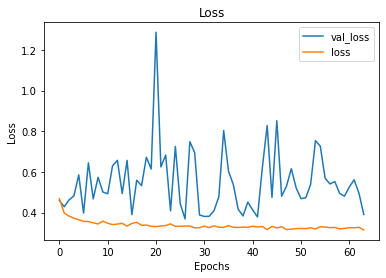

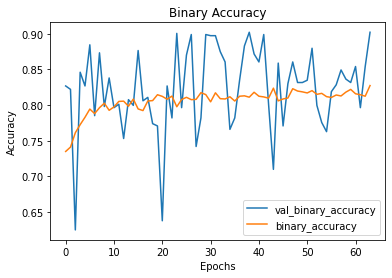

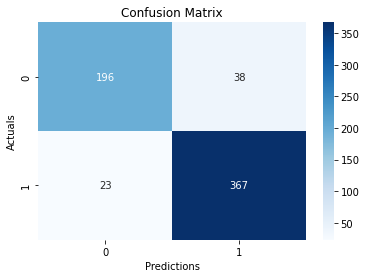

              precision    recall  f1-score   support

           0       0.89      0.84      0.87       234
           1       0.91      0.94      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624





Evaluating the Performance


Test Loss: 0.38365721702575684
Test Accuracy: 0.9022436141967773


In [30]:
visualize_training_results(results_3, pretrained_cnn, X_test, y_test)

In [31]:
!mkdir -p saved_model
pretrained_cnn.save('pretrained_cnn.h5')
pretrained_cnn.save_weights('pretrained_weights.h5')

# **Transfer Learning CNN Results.**
- Using VGG16, we were able to achieve 90% accuracy.
- Confusion Matrix actually was able to show us True Positives and True Negatives. 
- We were able to achieve this using VGG16, early stopping, different activation, and different optimizer. 
- Both curves never smooth out and stabilize.